<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bot basado en reglas con DNN + Spacy

#### Datos
Este ejemplo se inspiró en otro Bot en inglés creado con NLTK, lo tienen como referencia para hacer lo mismo en inglés:\
[LINK](https://towardsdatascience.com/a-simple-chatbot-in-python-with-deep-learning-3e8669997758)

### 1 - Instalar dependencias
Para poder utilizar Spacy en castellano es necesario agregar la librería "spacy-stanza" para lematizar palabras en español.

In [35]:
# La última versión de spacy-stanza (>1.0) es compatible solo con spacy >=3.0
# Nota: spacy 3.0 incorpora al pepiline nlp transformers
!pip install -U spacy==3.3 --quiet
!pip install -U spacy-stanza==1.0.0 --quiet

In [36]:
import json
import string
import random 
import numpy as np

import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout

In [37]:
import stanza
import spacy_stanza

# Vamos a usar SpaCy-Stanza. Stanza es una librería de NLP de Stanford
# SpaCy armó un wrapper para los pipelines y modelos de Stanza
# https://stanfordnlp.github.io/stanza/

# Descargar el diccionario en español y armar el pipeline de NLP con spacy
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

2022-07-11 16:09:37 INFO: Downloading default packages for language: es (Spanish)...
2022-07-11 16:09:39 INFO: File exists: /root/stanza_resources/es/default.zip.
2022-07-11 16:09:50 INFO: Finished downloading models and saved to /root/stanza_resources.
2022-07-11 16:09:50 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

2022-07-11 16:09:50 INFO: Use device: cpu
2022-07-11 16:09:50 INFO: Loading: tokenize
2022-07-11 16:09:50 INFO: Loading: mwt
2022-07-11 16:09:50 INFO: Loading: pos
2022-07-11 16:09:51 INFO: Loading: lemma
2022-07-11 16:09:51 INFO: Loading: depparse
2022-07-11 16:09:52 INFO: Loading: ner
2022-07-11 16:09:53 INFO: Done loading processors!


### 2 - Herramientas de preprocesamiento de datos
Entre las tareas de procesamiento de texto en español se implementa:
- Quitar acentos y caracteres especiales
- Quitar números
- Quitar símbolos de puntuación

In [38]:
import re
import unicodedata

# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):    
    # sacar tildes de las palabras
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntiación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

### 3 - Diccionario de entrada

In [39]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
dataset = {"intents": [
             {"tag": "bienvenida",
              "patterns": ["Hola", "¿Cómo estás?", "¿Qué tal?"],
              "responses": ["Hola! ¿Cual es tu pedido?", "Hola, ¿Cómo estás?. Te tomo tu pedido."],
             },
             {"tag": "bienvenida_dia",
              "patterns": ["Buen dia", "Buenos días", "Hola, buen día", "Hola, buenos dias!"],
              "responses": ["Buenos días! ¿Qué vas a pedir: helado en cucurucho, helado por kilo, torta helada, bombon suizo o escoses?"],
             },
             {"tag": "bienvenida_tarde",
              "patterns": ["Buenas tardes", "Hola buenas tardes!"],
              "responses": ["Buenas tardes! ¿Qué vas a pedir: helado en cucurucho, helado por kilo, torta helada, bombon suizo o escoses?"],
             },
             {"tag": "bienvenida_noche",
              "patterns": ["Buenas noches", "Hola, buenas noches!"],
              "responses": ["Hola! ¿Qué vas a pedir: helado en cucurucho, helado por kilo, torta helada, bombon suizo o escoses?", "Buenas noches, ¿Qué vas a querer de postre: helado en cucurucho, helado por kilo, torta helada, bombon suizo o escoses?"],
             },
             {"tag": "helado",
              "patterns": ["cucurucho", "Quiero un cucurucho", "Helado de una bocha", "Helado de dos bochas", "Helado de tres bochas", "bochas", "Quiero un cuarto de helado", "Quiero medio kilo de helado", "Quiero un kilo de helado", "Un cuarto de kilo", "Medio kilo", "Un kilo"],
              "responses": ["Ok, los gustos los podés pedir a través de la app. ¿Queres retirarlo en sucursal o te lo enviamos a domicilio?", "Genial! Pedí los gustos en la app. ¿Queres retirarlo en sucursal o te lo enviamos a domicilio?"],
             },
             {"tag": "torta_helada",
              "patterns": ["Torta helada", "Quiero una torta helada", "Torta"],
              "responses": ["Ok, podes ver nuestras tortas en la app. ¿Queres retirarla en sucursal o te la enviamos a domicilio?", "Ok, ¿Queres retirarla en sucursal o te la enviamos a domicilio?"],
             },
             {"tag": "bombones",
              "patterns": ["Quiero un bombón escoses", "Bombon escoses", "Quiero un bombón suizo", "Bombon suizo"],
              "responses": ["Bien, ¿Queres retirarlos en sucursal o te los enviamos a domicilio?"],
             },        
             {"tag": "envio_domicilio",
              "patterns": ["A domicilio por favor", "Domicilio", "¿Me lo pueden envíar?", "Envío"],
              "responses": ["Ok, te lo enviamos a tu casa. ¿cómo vas a abonar?", "Sale para tu casa. ¿Cómo querés abonar?"],
             },
             {"tag": "retiro_sucursal",
              "patterns": ["Retiro", "Paso a buscarlo", "Lo retiro en sucursal", "Paso más tarde"],
              "responses": ["Perfecto, te esperamos!", "Dale, pasá cuando quieras!", "Genial, estamos hasta las 23 hs."],
             },
             {"tag": "pago",
              "patterns": ["Voy a abonar en efectivo", "Efectivo", "Débito", "Crédito", "Pago con débito", "Voy a pagar con tarjeta de crédito"],
              "responses": ["Perfecto!, Muchas gracias por tu compra!", "Ok, muchas gracias por elegirnos!", "Gracias, te esperamos nuevamente!"]
             },
             {"tag": "agradecimientos",
              "patterns": ["Muchas gracias", "Gracias"],
              "responses": ["Por nada!, cualquier otra consulta podes escribirme"]
             },
             {"tag": "despedida",
              "patterns": [ "Chau", "Hasta luego!", "Adiós"],
              "responses": ["Hasta luego!", "Hablamos luego!"]
             }

]}

### 4 - Preprocesamiento y armado del dataset

In [40]:
# Datos que necesitaremos, las palabras o vocabilario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterízan
# a esa intención y transformarla a tokens para lamacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:            
            words.append(token.lemma_)
        
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

In [41]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['a', 'abonar', 'adios', 'bocha', 'bombon', 'buen', 'buscarlo', 'chau', 'como', 'con', 'credito', 'cuarto', 'cucurucho', 'de', 'debito', 'dia', 'domicilio', 'dos', 'efectivo', 'en', 'enviar', 'escose', 'este', 'favor', 'gracias', 'hasta', 'helado', 'holar', 'ir', 'kilo', 'luego', 'mas', 'medio', 'mucho', 'noche', 'pagar', 'pago', 'paso', 'poder', 'por', 'que', 'querer', 'retiro', 'sucursal', 'suizo', 'tal', 'tarde', 'tarjeta', 'torta', 'tres', 'uno', 'yo', 'él']
classes: ['agradecimientos', 'bienvenida', 'bienvenida_dia', 'bienvenida_noche', 'bienvenida_tarde', 'bombones', 'despedida', 'envio_domicilio', 'helado', 'pago', 'retiro_sucursal', 'torta_helada']
doc_X: ['Hola', '¿Cómo estás?', '¿Qué tal?', 'Buen dia', 'Buenos días', 'Hola, buen día', 'Hola, buenos dias!', 'Buenas tardes', 'Hola buenas tardes!', 'Buenas noches', 'Hola, buenas noches!', 'cucurucho', 'Quiero un cucurucho', 'Helado de una bocha', 'Helado de dos bochas', 'Helado de tres bochas', 'bochas', 'Quiero un cuarto

In [42]:
# Tamaño del vocabulario
print("Vocabulario:", len(words))

Vocabulario: 53


In [43]:
# Cantidad de tags
print("Tags:", len(classes))

Tags: 12


In [44]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    
    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 1, 0, 0, 0, 0, 

### 5 - Entrenamiento del modelo

In [45]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (53,) output: 12


In [46]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               6912      
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 12)                780       
                                                                 
Total params: 15,948
Trainable params: 15,948
Non-trainable params: 0
_________________________________________________________________
None


In [47]:
hist = model.fit(x=train_X, y=train_y, epochs=200)

Epoch 1/200
2/2 [==============================] - 1s 10ms/step - loss: 2.4706 - accuracy: 0.1224
Epoch 2/200
2/2 [==============================] - 0s 8ms/step - loss: 2.4797 - accuracy: 0.1837
Epoch 3/200
2/2 [==============================] - 0s 11ms/step - loss: 2.4417 - accuracy: 0.1837
Epoch 4/200
2/2 [==============================] - 0s 9ms/step - loss: 2.3838 - accuracy: 0.2245
Epoch 5/200
2/2 [==============================] - 0s 8ms/step - loss: 2.3486 - accuracy: 0.2653
Epoch 6/200
2/2 [==============================] - 0s 9ms/step - loss: 2.3966 - accuracy: 0.2245
Epoch 7/200
2/2 [==============================] - 0s 9ms/step - loss: 2.3472 - accuracy: 0.2245
Epoch 8/200
2/2 [==============================] - 0s 9ms/step - loss: 2.3154 - accuracy: 0.2041
Epoch 9/200
2/2 [==============================] - 0s 8ms/step - loss: 2.3381 - accuracy: 0.2653
Epoch 10/200
2/2 [==============================] - 0s 8ms/step - loss: 2.3572 - accuracy: 0.2041
Epoch 11/200
2/2 [=========

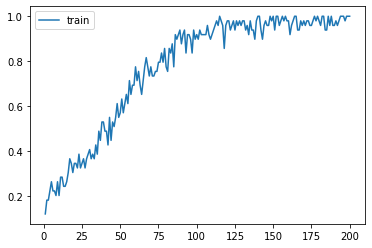

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [49]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# el vocabulario utilizado (words)
# las posibles clases
# el modelo
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

### 6 - Testing y validación

In [50]:
def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

def bag_of_words(text, vocab): 
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens: 
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

def pred_class(text, vocab, labels): 
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0:
        result = model.predict(np.array([bow]))[0]
        thresh = 0.2
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        y_pred.sort(key=lambda x: x[1], reverse=True)
    
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    return return_list

def get_response(intents_list, intents_json):
    tag = intents_list[0]
    list_of_intents = intents_json["intents"]
    for i in list_of_intents: 
        if i["tag"] == tag:
            result = "BOT: " + random.choice(i["responses"])
            break
    return result

In [51]:
bag_of_words('abonar', words)

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

In [52]:
words

['a',
 'abonar',
 'adios',
 'bocha',
 'bombon',
 'buen',
 'buscarlo',
 'chau',
 'como',
 'con',
 'credito',
 'cuarto',
 'cucurucho',
 'de',
 'debito',
 'dia',
 'domicilio',
 'dos',
 'efectivo',
 'en',
 'enviar',
 'escose',
 'este',
 'favor',
 'gracias',
 'hasta',
 'helado',
 'holar',
 'ir',
 'kilo',
 'luego',
 'mas',
 'medio',
 'mucho',
 'noche',
 'pagar',
 'pago',
 'paso',
 'poder',
 'por',
 'que',
 'querer',
 'retiro',
 'sucursal',
 'suizo',
 'tal',
 'tarde',
 'tarjeta',
 'torta',
 'tres',
 'uno',
 'yo',
 'él']

In [53]:
while True:
    message = input("")
    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print(result)
    else:
        print("Perdón, no comprendo la pregunta.")
    

KeyboardInterrupt: ignored

### 7 - Conclusiones
El bot tal cual está definido es capaz de responder a bastantes tipos de preguntas con gran precisión. Algunas técnicas que podrían ensayarse para evaluar como impactan en el sistema son:
- Filtrar los stop words
- Utilizar TF-IDF en vez de bag of words